Student Name: Xuxu Pan and Wenjie Duan
--

Data Cleaning
--

In [1]:
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(scales)

array(['scales', 'ggplot2', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [2]:
import numpy as np
import pandas as pd

In [3]:
# read data
# would join table later
ride = pd.read_csv('cab_rides.csv')
weather = pd.read_csv('weather.csv')

In [4]:
print(len(ride))
print(len(weather))

693071
6276


In [5]:
# deal with time series 
ride['time'] = pd.to_datetime(ride.time_stamp/1000,unit='s')
weather['time'] = pd.to_datetime(weather.time_stamp,unit = 's')
ride['date'] = ride.time.dt.date.astype('str')
weather['date'] = weather.time.dt.date.astype('str')
ride['hour'] = ride.time.dt.hour.astype('str')
weather['hour'] = weather.time.dt.hour.astype('str')
ride['dow'] = ride.time.dt.dayofweek.astype('int')
weather['dow'] = weather.time.dt.dayofweek.astype('int')
ride = ride.drop(columns=['time_stamp'])
weather = weather.drop(columns=['time_stamp'])

In [6]:
# merge by time and location 
df = pd.merge(ride, weather, left_on = ['date','hour','dow','source']
              , right_on = ['date','hour','dow','location'], how = 'left')
# drop unnecessary cols
df = df.drop(columns = ['destination', 'id', 'product_id','location'])
# change df type, prepare to load into R
def trans(df):
    for col in df:
        if df[col].dtypes == 'object':
            df[col] = df[col].fillna('nan')
    return df
df = trans(df)

In [7]:
# combine cab company and its cab type
df['type_name'] = df.cab_type+"_"+ df.name
# Select distinguished line, make sure we compare Apple to Apple  
# Name: Share, Normal, XL, Black
# lyft: Shared, Lyft, lyft XL, Lux Black
# Uber: UberPool, UberX, UberXL, Black
df = df[df.name.isin(['Shared', 'Lyft', 'Lyft XL', 'Lux Black',
       'UberXL', 'Black', 'UberX', 'UberPool'])]

In [8]:
# unit price per mile 
df['unitp'] = df.price/df.distance

In [9]:
# unit price of tempreture below and above 32 F
df.loc[(df.temp>=32),"above0"]=df.unitp
df.loc[(df.temp<32),"below0"]=df.unitp

Graph 1: Uber vs Lyft in Average Price
--

In [10]:
# compare generally between Uber and Lyft
df_total = df.groupby('cab_type').mean()[['unitp']].reset_index()
df_total

,cab_type,unitp
0,Lyft,7.436376
1,Uber,8.203697


In [11]:
%R -i df_total 

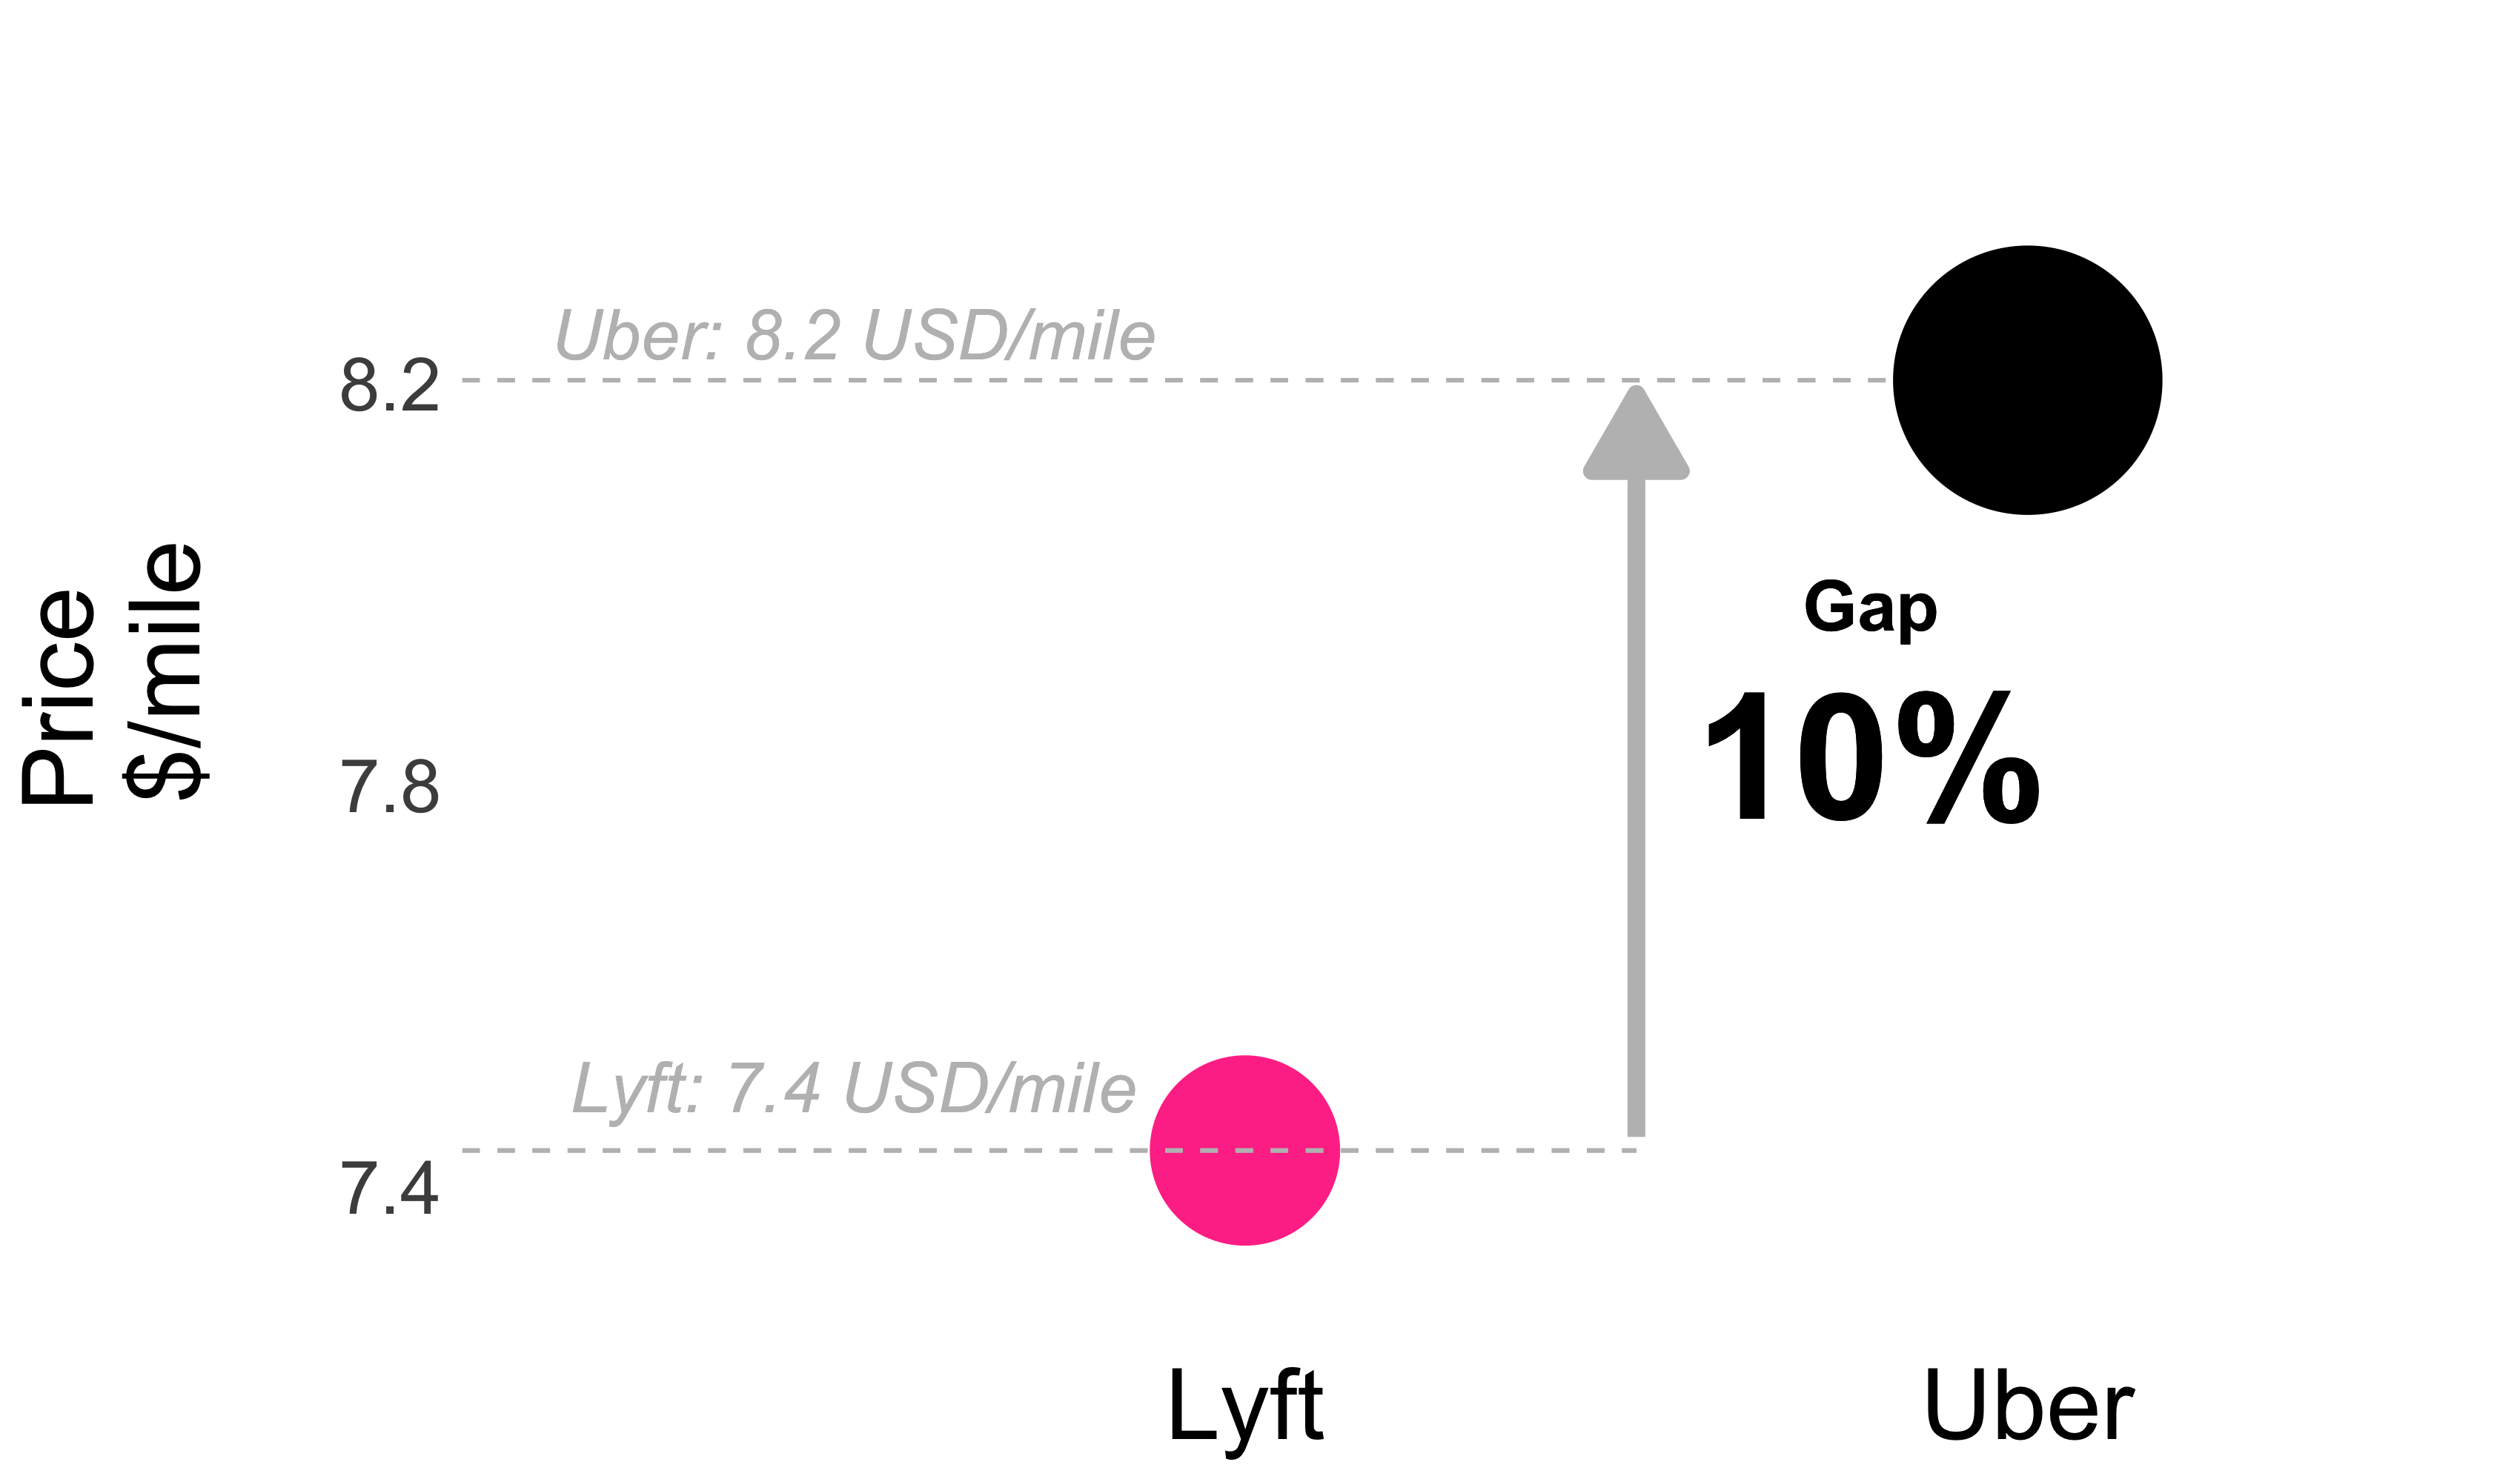

In [12]:
%%R -w 8.5 -h 5 --unit in -r 400
ggplot() +
    geom_point(aes(x = cab_type, y = unitp, size = cab_type, color =cab_type ), 
             data = df_total, stat = "identity")+
    scale_color_manual(values = c('violetred1','black')) +
    scale_size_discrete(range = c(21, 30))+


    ylab('Price \n $/mile\n')+
    scale_y_continuous(limits = c(7.3,8.5), breaks = seq(7,8.5,by = 0.4))+

    geom_segment( aes(x = 1.5, xend = 1.5, y = 7.45, yend=8.19)
                 , data = df_total, size = 2, color = 'grey'
                 , arrow = arrow(length = unit(0.3, "inches")
                                 ,type='closed')) +
    geom_segment( aes(x =0 , xend = 1.5, y = 7.436376, yend=7.436376)
                 , data = df_total, size = 0.5, color = 'grey'
                 , linetype = 'dashed')+
    geom_segment( aes(x =0 , xend = 1.84, y = 8.203697, yend=8.203697)
                 , data = df_total, size = 0.5, color = 'grey'
                 , linetype = 'dashed')+
    geom_text(aes(label= 'Uber: 8.2 USD/mile',x = 0.5 , y = 8.25), 
           data = df_total, size = 6,colour = 'grey'
              ,fontface = "italic")+
    geom_text(aes(label= 'Lyft: 7.4 USD/mile',x = 0.5 , y = 7.5), 
           data = df_total, size = 6,colour = 'grey',
              fontface = "italic")+

    geom_text(aes(label= 'Gap',x = 1.8 , y = 7.98), 
           data = df_total, size = 6,colour = 'black'
              ,fontface = 'bold')+
    geom_text(aes(label= '10%',x = 1.8 , y = 7.83), 
           data = df_total, size = 15,colour = 'black'
              ,fontface = 'bold')+
    guides(color=F)+ 
    guides(size=F)+ 
    theme_minimal()+
    theme(axis.text.y   = element_text(size=18),
        axis.text.x   = element_text( size=24, color = 'black'),
        axis.title.y  = element_text( size=24, color = 'black'),
        axis.title.x  = element_blank(),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank())+
    ggsave('/Users/xuxupan/Desktop/1.png', units = 'in'
           , width = 8.5, height = 5)

Graph 2: Uber vs Lift in 4 different product type
--

In [13]:
df_types = df.groupby('type_name').mean()['unitp'].reset_index()
df_types['types'] = ['Black','Normal','XL','Share','Black','Share','Normal','XL']
df_types['company'] = df_types.type_name.str[:4]
df_types['level'] = [4,2,3,1,4,1,2,3] 
df_types['unip'] = df_types.unitp.round(2)
# sort by level (price level, car level)
df_types = df_types.sort_values('level')
df_types.types = pd.Categorical(df_types.types
                                       ,categories=list(df_types.types.unique())
                                , ordered = True)

In [14]:
%R -i df_types

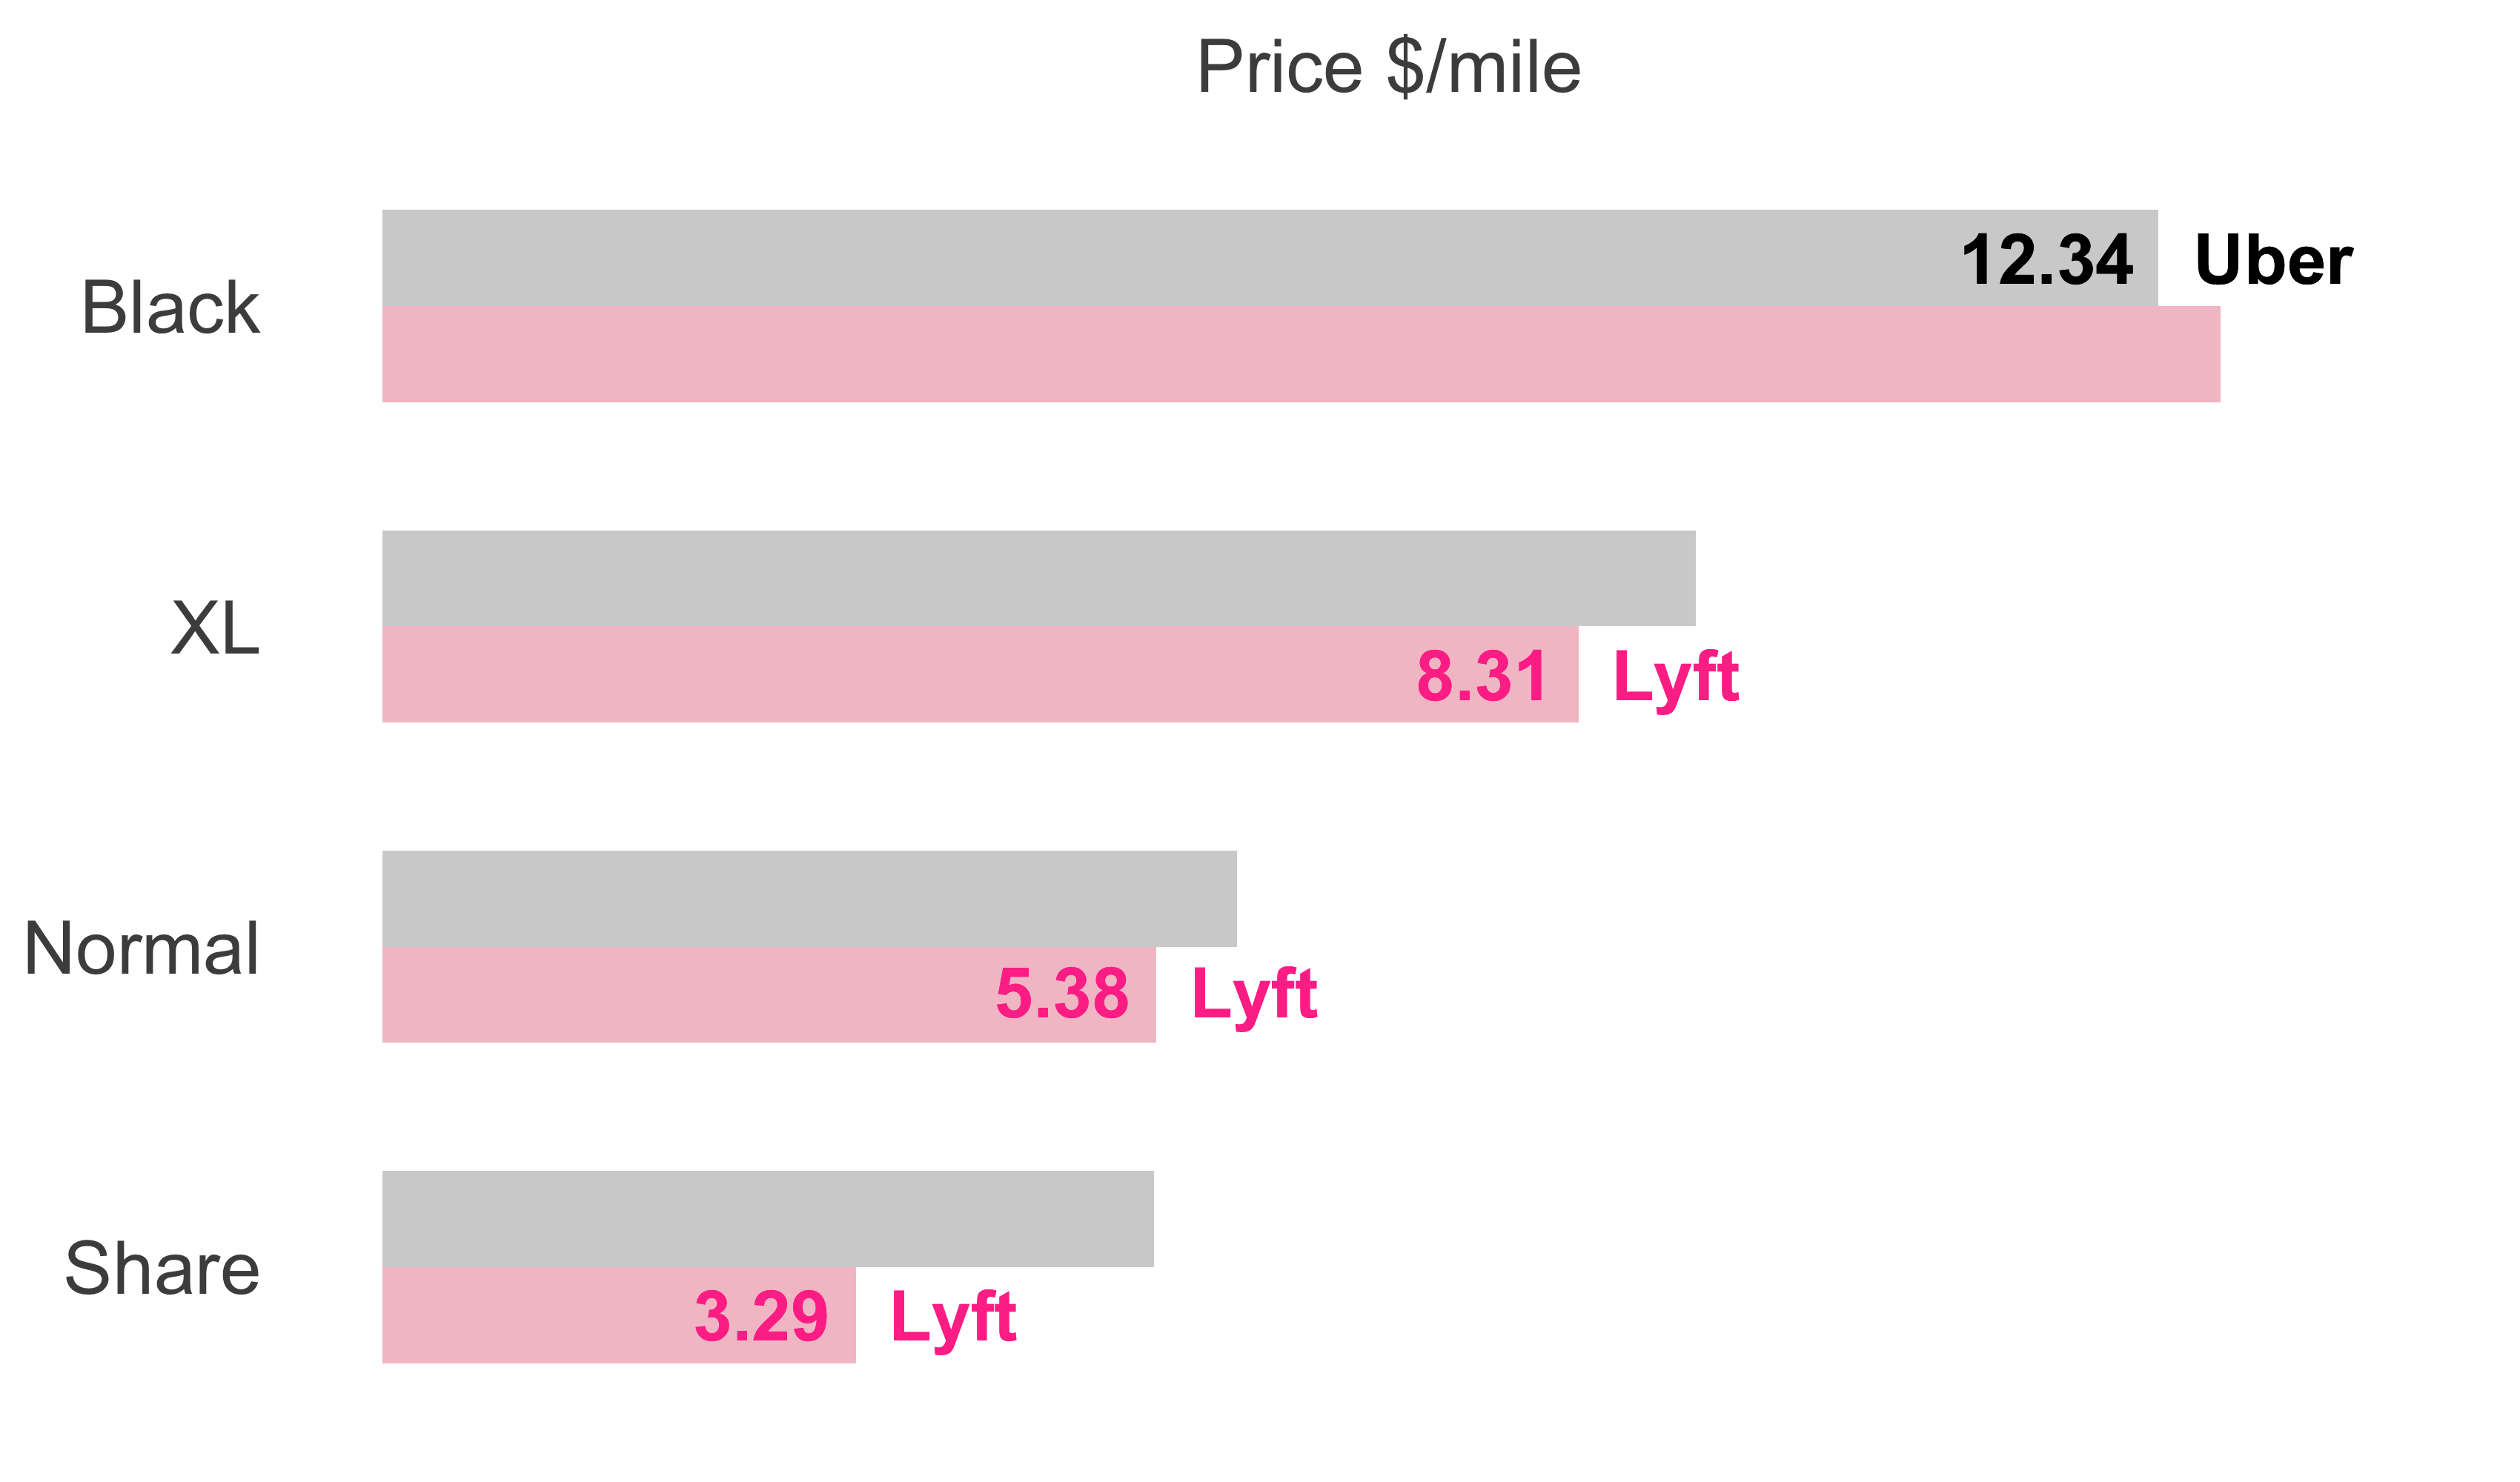

In [15]:
%%R -w 8.5 -h 5 --unit in -r 400
ggplot(aes(x = types, y = unitp), data = df_types)+
    geom_bar(aes(fill = company ), position = "dodge", 
                       stat = "identity", width = 0.6, alpha = 0.7)+
    scale_fill_manual(values = c('pink2', 'grey')) +
    ylab('Price $/mile')+
    scale_y_continuous(limits = c(0,14)
                       , breaks = seq(0,14,by = 2),position= 'right')+

    geom_text(aes(label= '3.29   Lyft',x = 0.85 , y = 3.29), 
           data = df_total, size = 6,colour = 'violetred1'
              ,fontface = "bold")+
    geom_text(aes(label= '5.38   Lyft',x = 1.86 , y = 5.38), 
           data = df_total, size = 6,colour = 'violetred1'
              ,fontface = "bold")+
    geom_text(aes(label= '8.31   Lyft',x = 2.85 , y = 8.31), 
           data = df_total, size = 6,colour = 'violetred1'
              ,fontface = "bold")+
    geom_text(aes(label= '12.34   Uber',x = 4.15 , y = 12.33), 
           data = df_total, size = 6,colour = 'black'
              ,fontface = "bold")+

    guides(fill=F)+ 
    theme_minimal()+
    theme(axis.text.x   = element_blank(),
        axis.text.y   = element_text( size=18, color = 'grey30'),
        axis.title.y  = element_blank(), 
        axis.title.x  = element_text( size=18, color = 'grey30'),
        #panel.background = element_blank(),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        axis.ticks.y = element_blank())+
        coord_flip()+
    ggsave('/Users/xuxupan/Desktop/2.png', units = 'in'
           , width = 8.5, height = 5)

Graph 3: Surge Multiplier
    --

In [16]:
df.loc[df.surge_multiplier> 1, 'sm'] = 1
df.loc[df.surge_multiplier> 1, 'smup'] = df.unitp
dfsm = df.groupby('cab_type').agg({'smup':'mean'
                                   ,'sm':'count','unitp':['count','mean']}
                                 ).reset_index()
#surge multiplier table 
dfsm.columns = ['type_name','smavgp','smcnt','ttlcnt','ttlavgp']
dfsm['pctp'] = round(dfsm.smavgp/dfsm.ttlavgp,2)
dfsm['pctc'] = round(dfsm.smcnt/dfsm.ttlcnt,4)
dfsm = dfsm.fillna(0)
pctc = dfsm['pctc'][0]
percentage = "{0:.2%}".format(pctc)
print(percentage)

6.14%


In [17]:
dfsm_lyft = dfsm[dfsm.type_name=='Lyft']
before_surge = float(dfsm_lyft.ttlavgp.values)
after_surge = float(dfsm_lyft.smavgp.values)
d = {'value': [before_surge, after_surge]
     , 'surge':['before surge','after surge']}
surge_lyft = pd.DataFrame(data = d)
# sort 
surge_lyft = surge_lyft.sort_values('value')
surge_lyft.surge = pd.Categorical(surge_lyft.surge
                                       ,categories=list(surge_lyft.surge)
                                  , ordered = True)
surge_lyft.value = surge_lyft.value.round(2)

In [18]:
%R -i surge_lyft

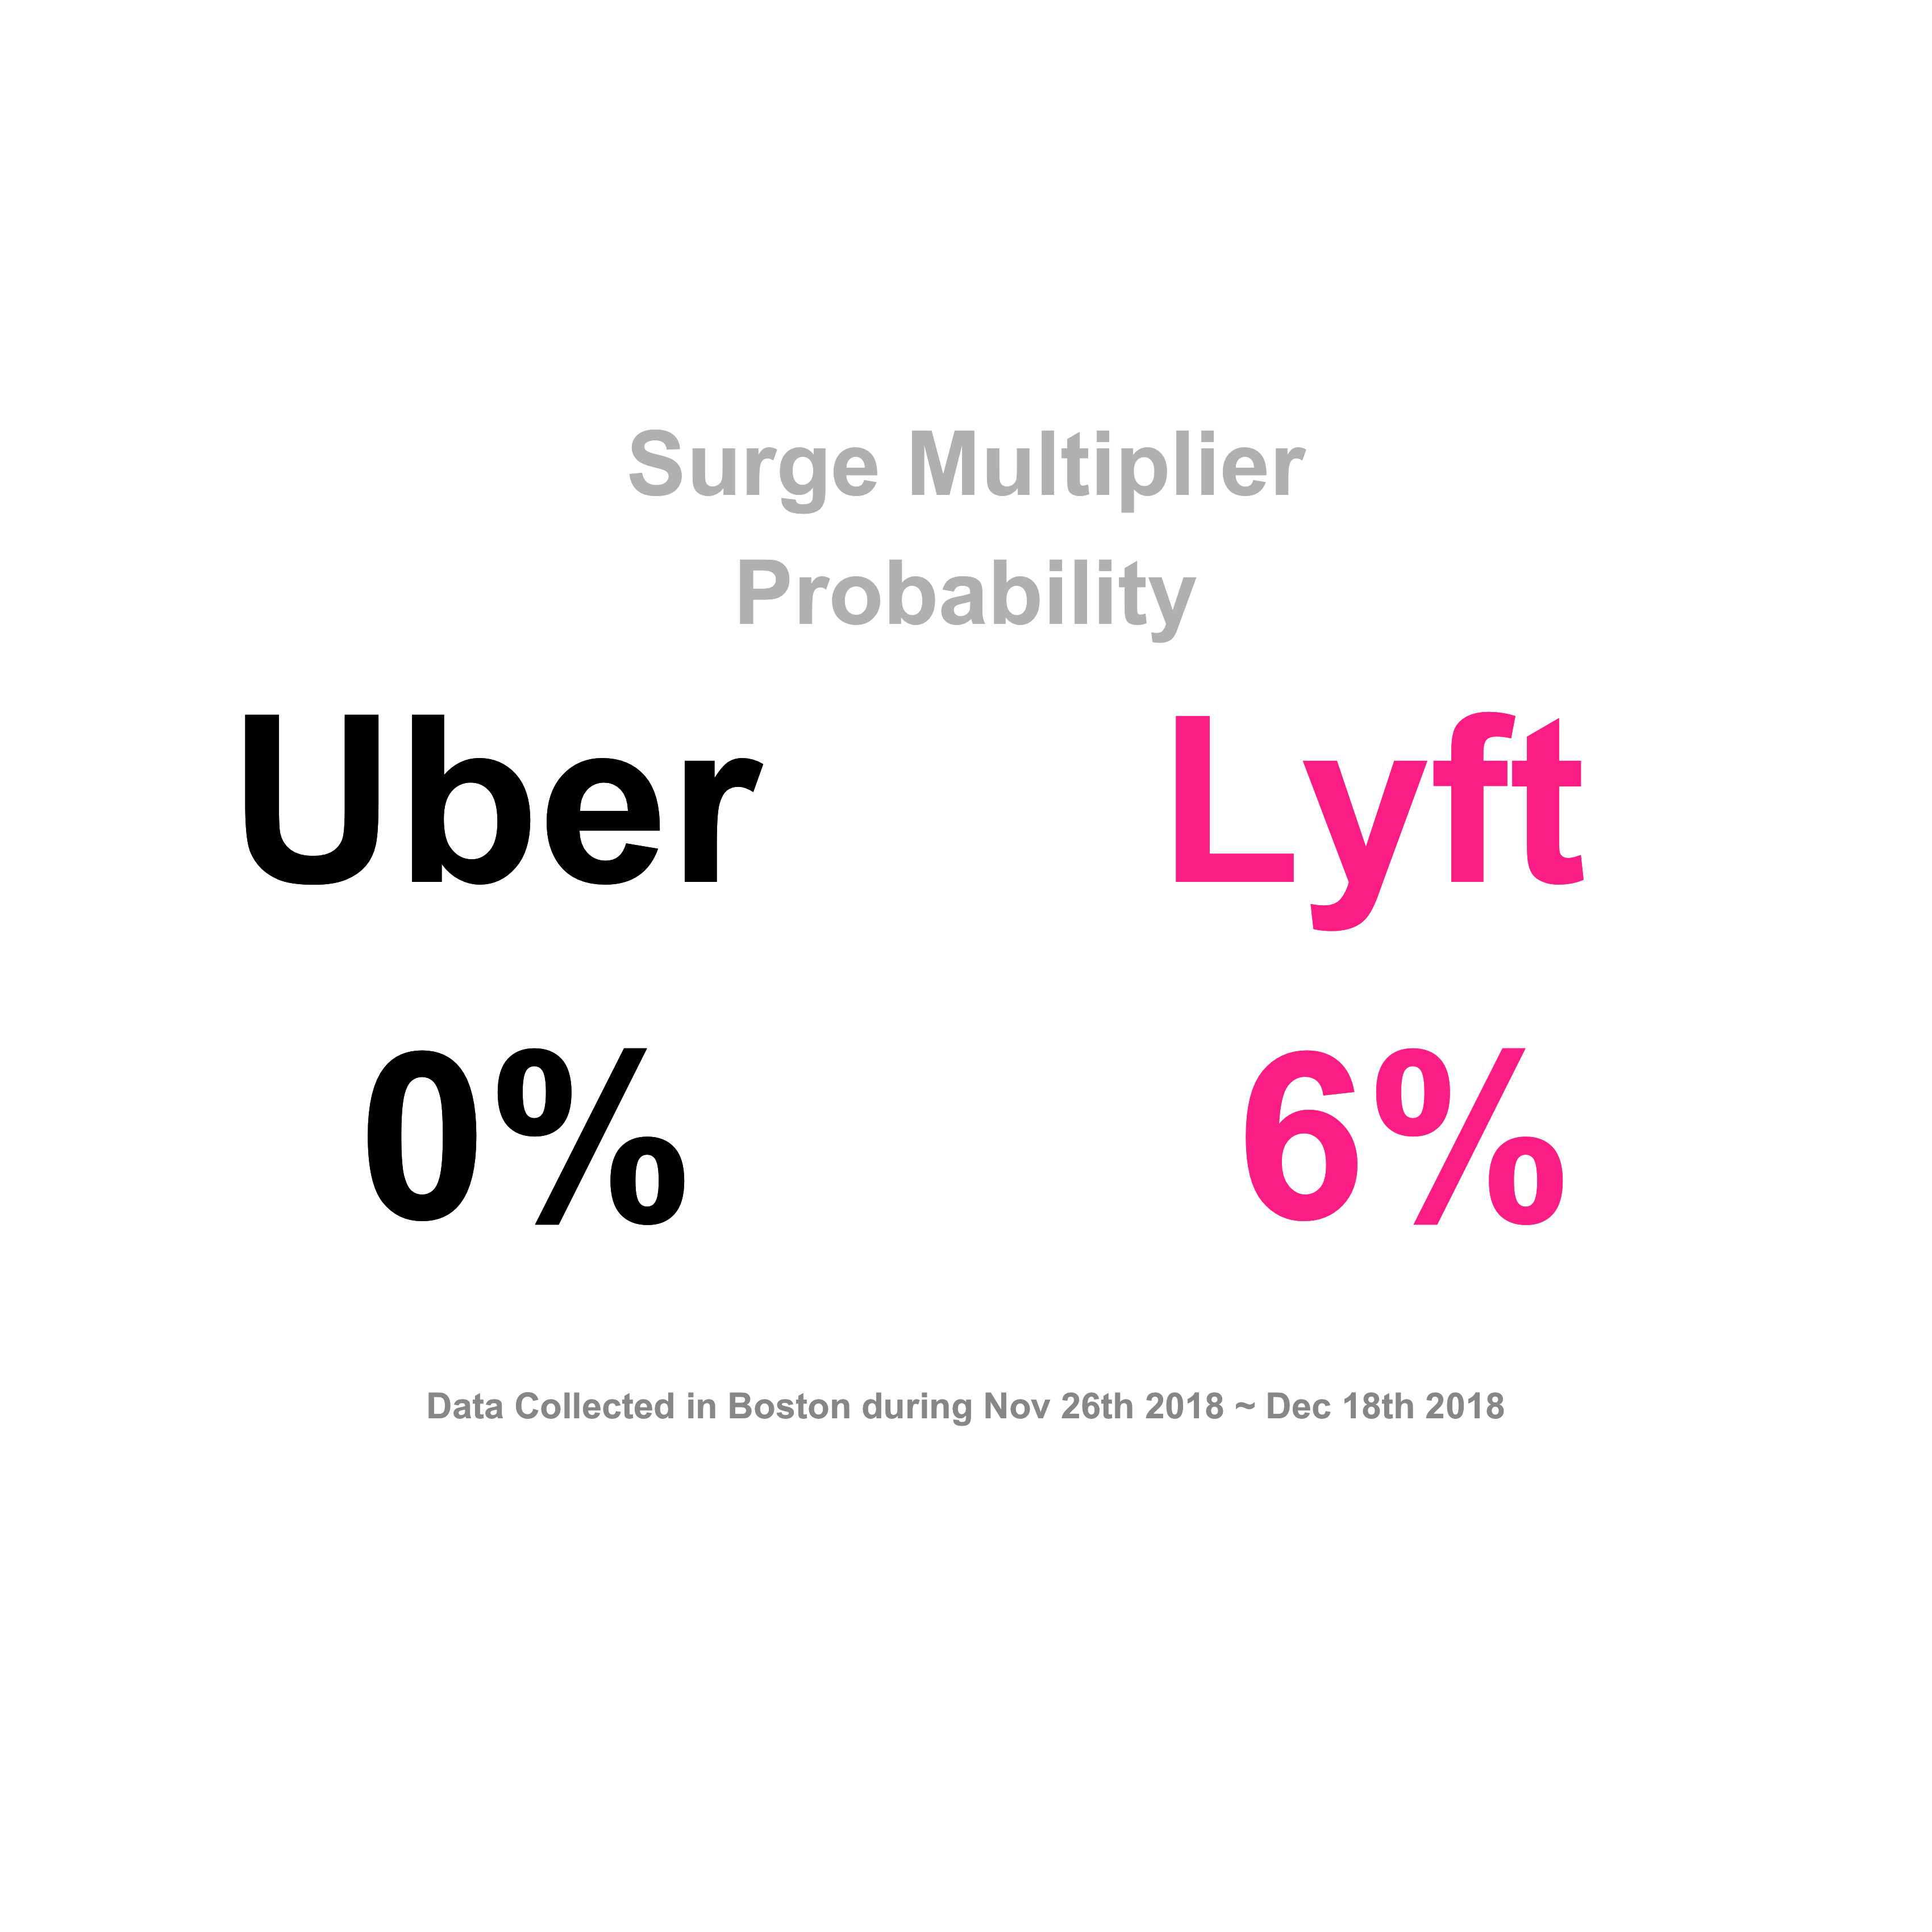

In [19]:
%%R -w 8.5 -h 8.5 --unit in -r 400
ggplot()+
    geom_text(aes(label= 'Surge Multiplier\nProbability',x = 1 , y = 1.5), 
           data = surge_lyft, size = 10,colour = 'grey'
              ,fontface = "bold")+
    geom_text(aes(label= 'Lyft \n6%',x = 1.5 , y = 1), 
           data = surge_lyft, size = 26,colour = 'violetred1'
              ,fontface = "bold")+
    geom_text(aes(label= 'Uber \n0%',x = 0.5 , y = 1), 
           data = surge_lyft, size = 26,colour = 'black'
              ,fontface = "bold")+
    geom_text(aes(label= 'Data Collected in Boston during Nov 26th 2018 ~ Dec 18th 2018'
                  ,x = 1 , y = 0.5), 
           data = surge_lyft, size = 4,colour = 'grey60'
              ,fontface = "bold")+
    scale_y_continuous(limits = c(0,2))+
    scale_x_continuous(limits = c(0,2))+
    theme_void()+
    ggsave('/Users/xuxupan/Desktop/3.png', units = 'in'
           , width = 8.5, height = 8.5)

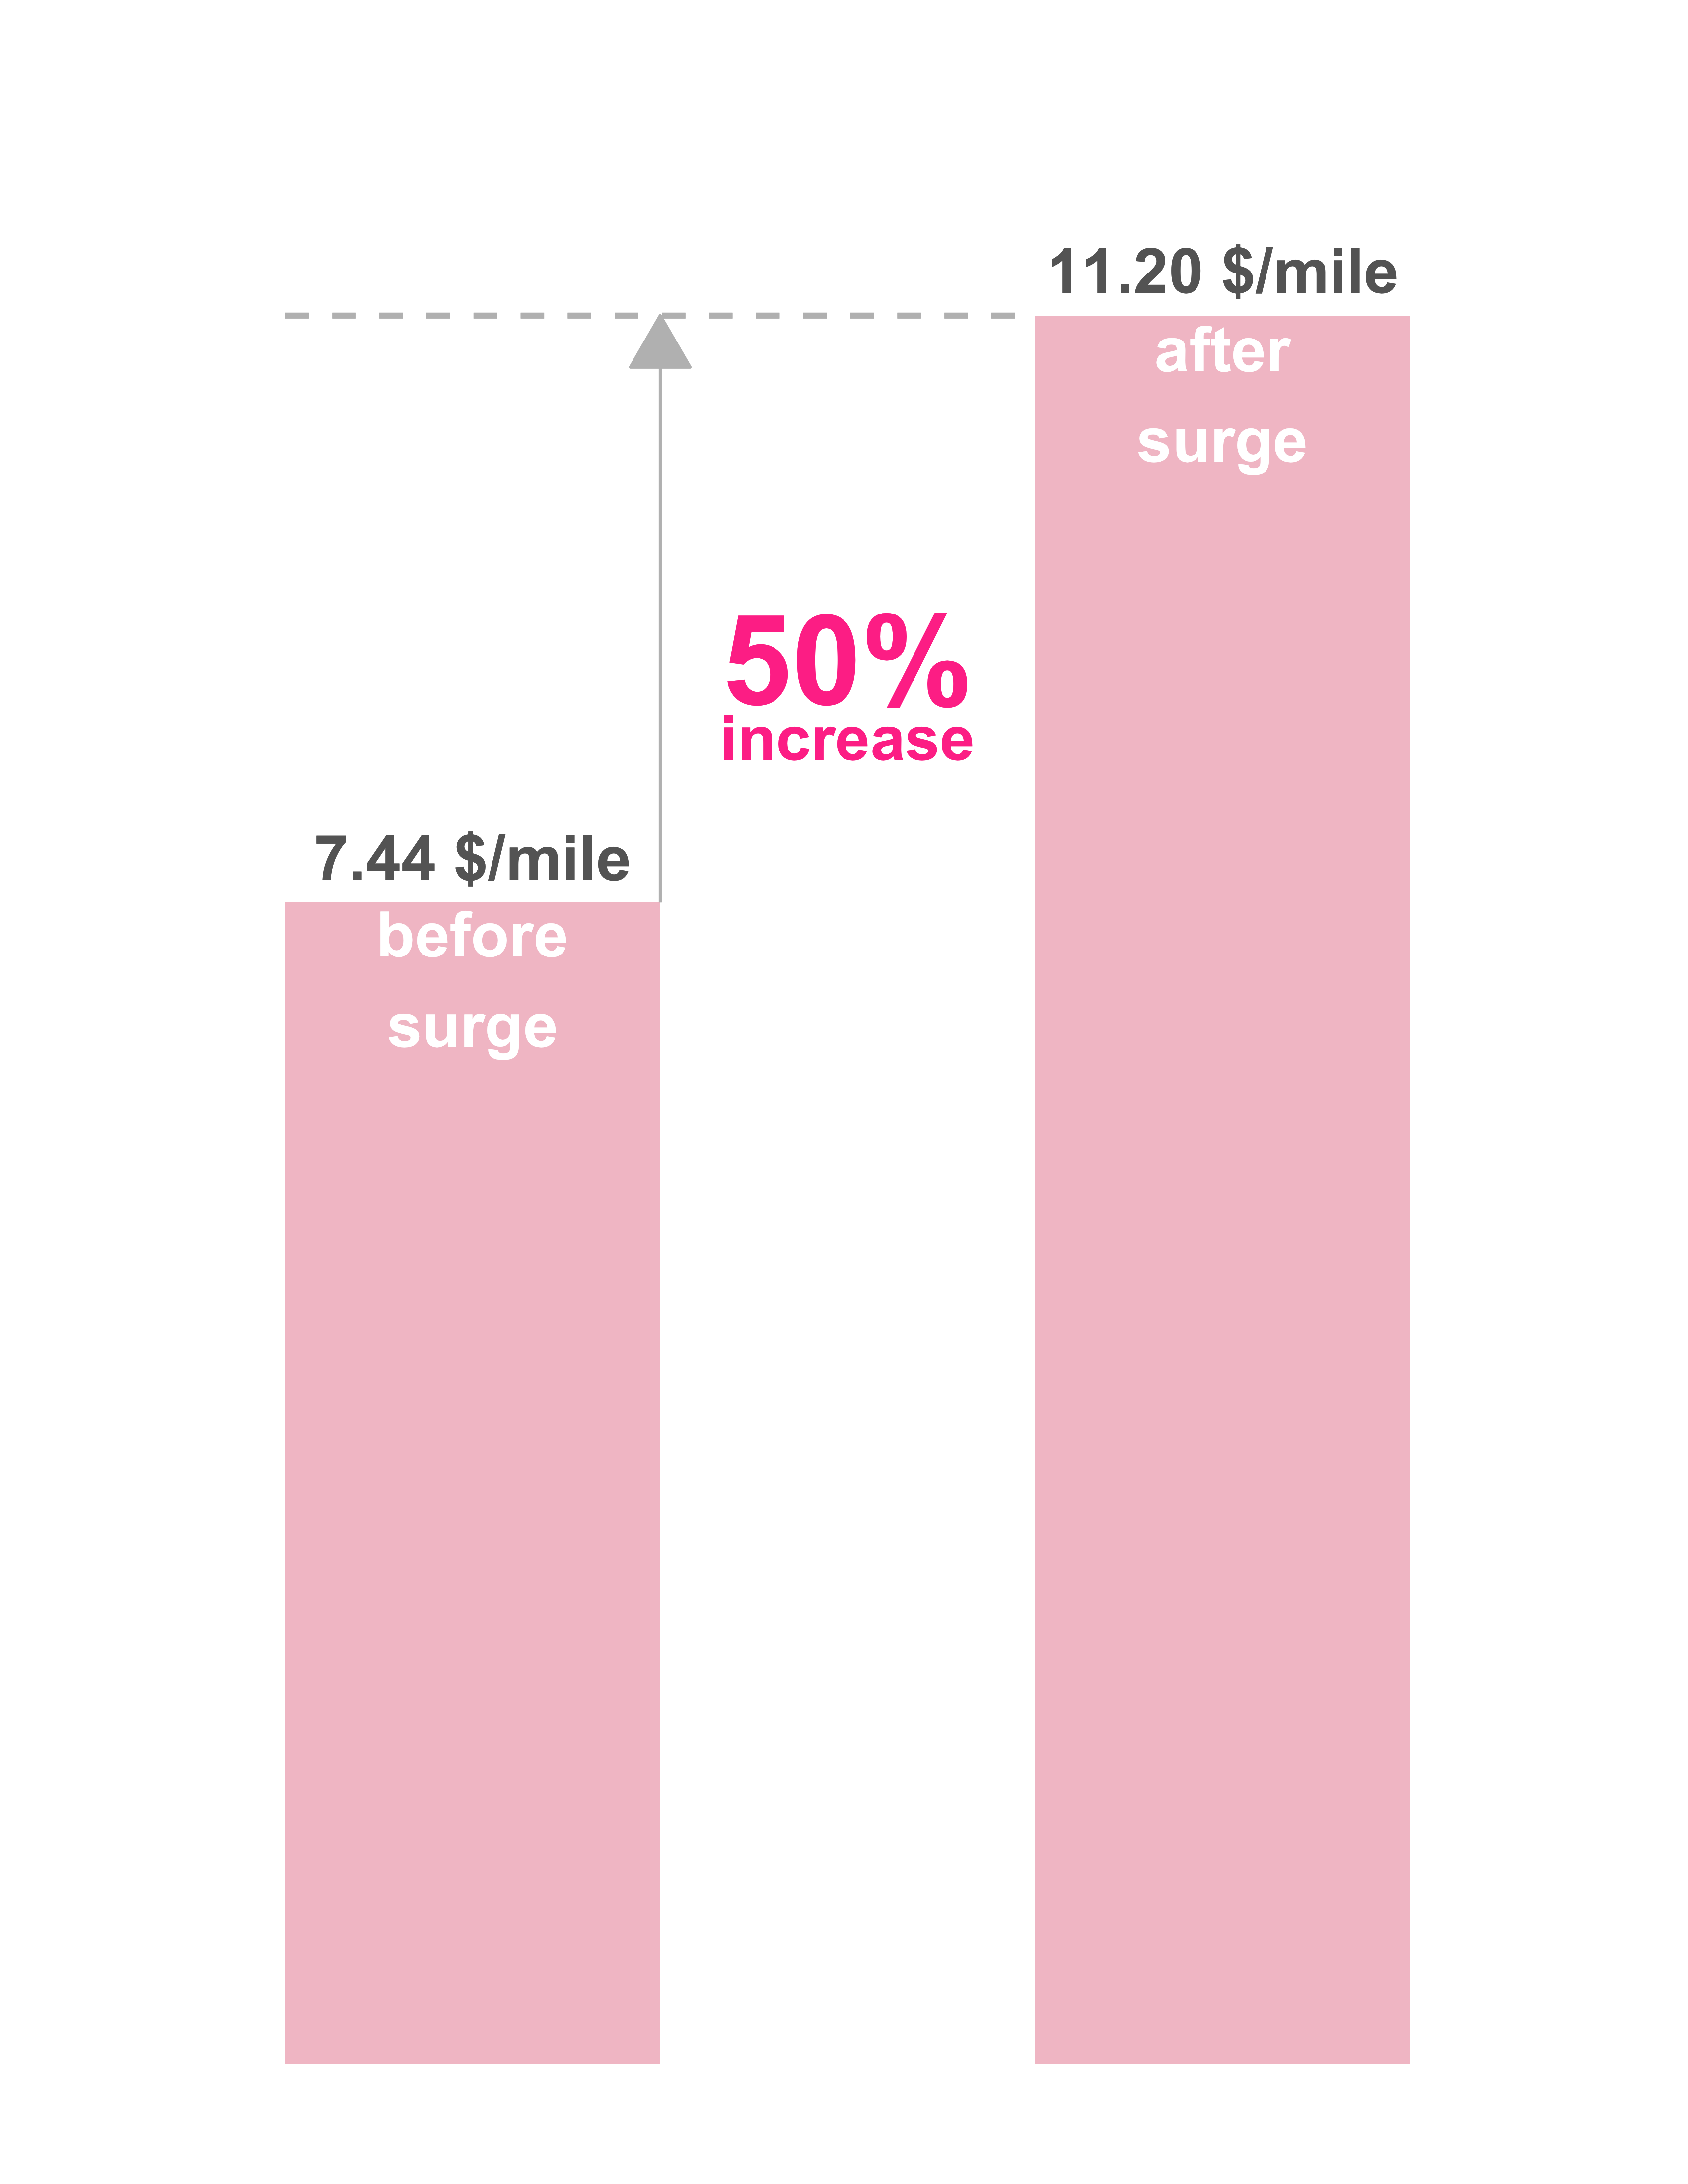

In [20]:
%%R -w 8.5 -h 11 --unit in -r 400
ggplot()+
    geom_bar(aes(x = surge, y = value )
             ,data =  surge_lyft, stat = "identity"
             , fill = 'pink2', width = 0.5, alpha = 0.7)+

    ylab('Price \n $/mile')+
    scale_y_continuous(limits = c(0,12.5)
                       , breaks = seq(0,12,by = 4))+

    geom_text(aes(label= '50%',x = 1.5 , y = 9), 
           data = surge_lyft, size = 16,colour = 'violetred1'
              ,fontface = "bold")+
    geom_text(aes(label= 'increase',x = 1.5 , y = 8.5), 
           data = surge_lyft, size = 8,colour = 'violetred1'
              ,fontface = "bold")+

    geom_segment( aes(x = 0.75, xend = 1.75, y = 11.2, yend=11.2)
                 , data = surge_lyft, size = 1, color = 'grey'
                 ,linetype = 'dashed') +
    geom_segment( aes(x =1.25 , xend = 1.25, y = 7.44, yend=11.2)
                 , data = surge_lyft, size = 0.5, color = 'grey'
                , arrow = arrow(length = unit(0.3, "inches")
                                ,type='closed'))+

    geom_text(aes(label= 'before\nsurge',x = 1, y = 6.95), 
           data = surge_lyft, size = 8,colour = 'white'
              ,fontface = "bold")+
    geom_text(aes(label= 'after\nsurge',x = 2, y = 10.7), 
           data = surge_lyft, size = 8,colour = 'white'
              ,fontface = "bold")+

    geom_text(aes(label= '7.44 $/mile\n',x = 1, y = 7.44), 
           data = surge_lyft, size = 8,colour = 'grey40'
              ,fontface = "bold")+
    geom_text(aes(label= '11.20 $/mile\n',x = 2, y = 11.20), 
           data = surge_lyft, size = 8,colour = 'grey40'
              ,fontface = "bold")+
    theme_minimal()+
    theme(axis.text.y   = element_blank(),
        axis.text.x   = element_blank(),
        axis.title.y  = element_blank(),
        axis.title.x  = element_blank(),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank())+
    ggsave('/Users/xuxupan/Desktop/4.png', units = 'in'
           , width = 8.5, height = 11)

Graph 4: time
    --

In [21]:
df.loc[(df.temp>=32),"above0"]=df.unitp
df.loc[(df.temp<32),"below0"]=df.unitp
df['hour'] = df['hour'].astype(int)
dfhr = (df.groupby(['hour','type_name']).mean()
        [['unitp']].reset_index())
dfhr["cab_type"] = dfhr.type_name.str[:4]
# distinguish cab type, in order to control line type
dfhr.loc[
    (dfhr.type_name == "Lyft_Lux Black")|(dfhr.type_name == "Uber_Black")
                                         ,"type"] = "'Black"
dfhr.loc[
    (dfhr.type_name == "Lyft_Lyft XL")|(dfhr.type_name == "Uber_UberXL")
                                         ,"type"] = "XL"
dfhr.loc[
    (dfhr.type_name == "Lyft_Lyft")|(dfhr.type_name == "Uber_UberX")
                                         ,"type"] = "Normal"
dfhr.loc[
    (dfhr.type_name == "Lyft_Shared")|(dfhr.type_name == "Uber_UberPool")
                                         ,"type"] = "Share"

In [22]:
%R -i dfhr

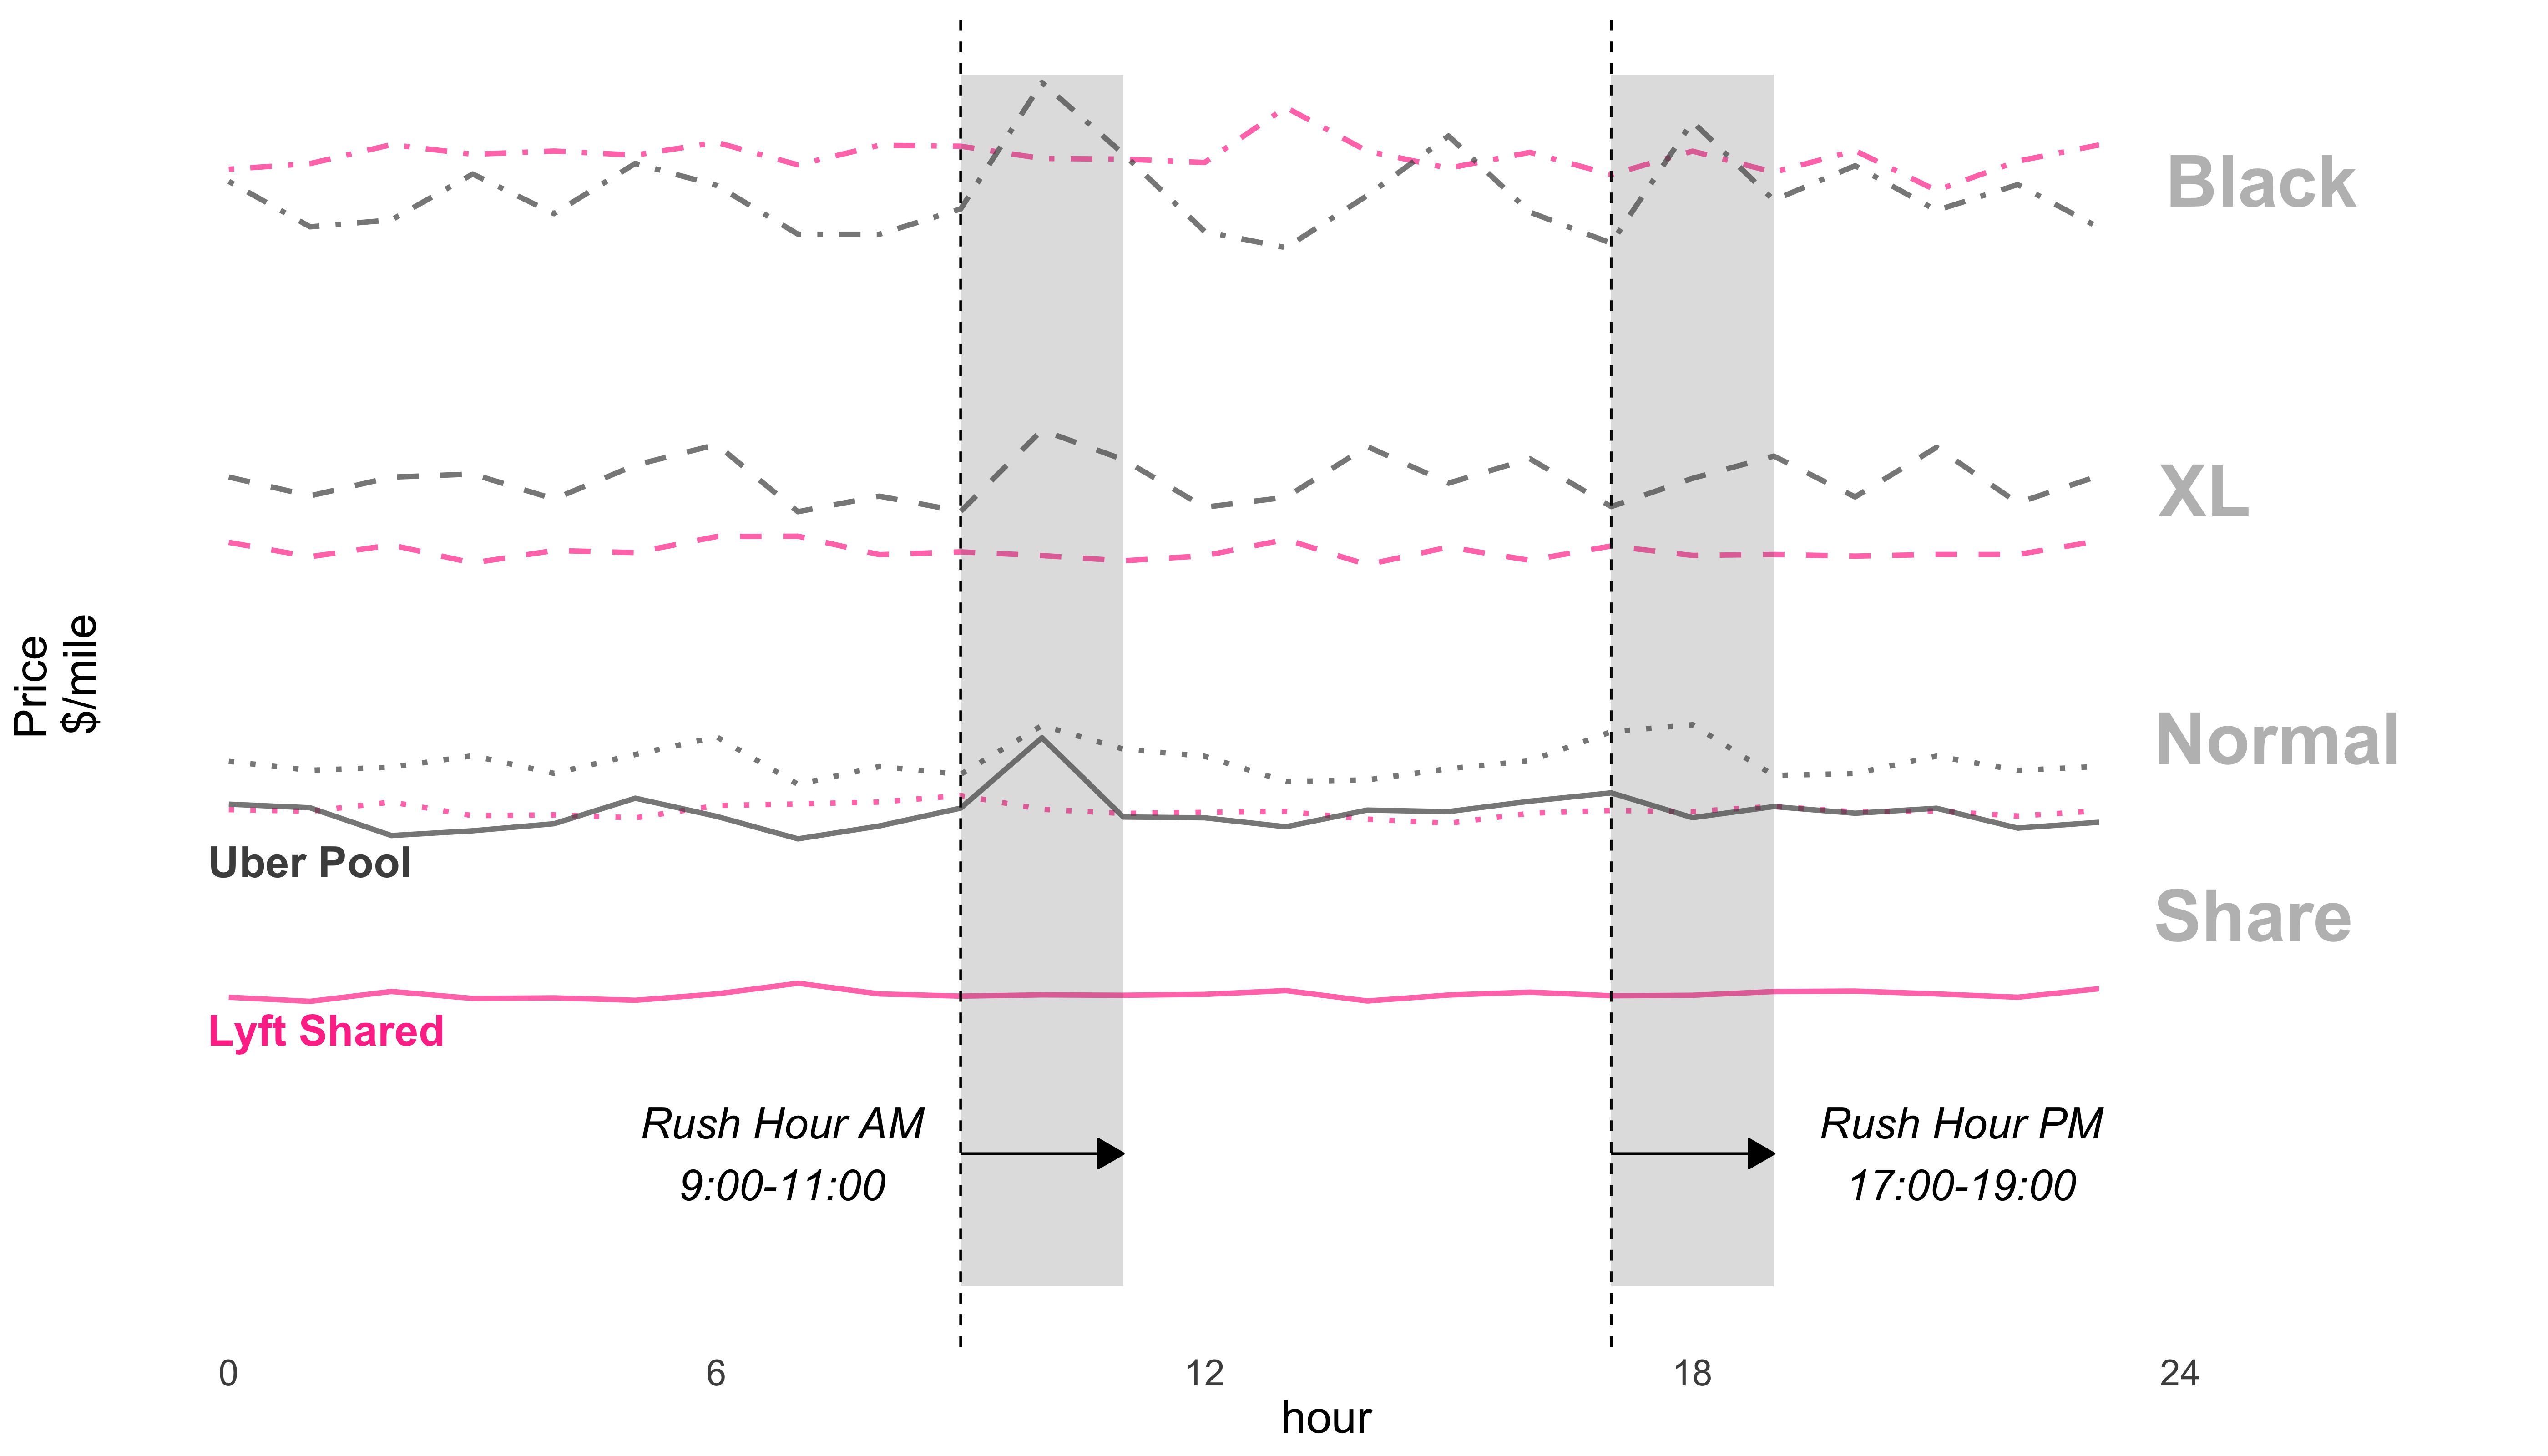

In [23]:
%%R -w 14 -h 8 --unit in -r 400
ggplot() + 
    geom_line(aes(x=hour,y=unitp,group = type_name
                  , linetype = type, color = cab_type)
              ,data = dfhr,size = 1,alpha = 0.7)+
    scale_x_continuous(limits = c(0,27)
                       , breaks = seq(0,24,by = 6))+

    geom_vline(xintercept = 9, linetype="dashed")+
    geom_vline(xintercept = 17, linetype="dashed")+

    annotate("rect", xmin = 9, xmax = 11, ymin = 0
             , ymax = 13.7, alpha = 0.2)+
    annotate("rect", xmin = 17, xmax = 19, ymin = 0
             , ymax = 13.7, alpha = 0.2)+
    scale_color_manual(values = c('violetred1', 'grey30'))+
    scale_linetype_manual(values = c('dotdash','dotted' 
                                     , 'solid','dashed' ))+
    annotate("text", x = 25,y = 12.5,label='Black'
         , size = 10, color = "grey", fontface = "bold")+
    annotate("text", x = 24.3,y = 9,label='XL'
             , size = 10,color = "grey", fontface = "bold")+
    annotate("text", x = 25.2,y = 6.2,label='Normal'
             , size = 10,color = "grey", fontface = "bold")+
    annotate("text", x = 24.9,y = 4.2,label='Share'
             , size = 10,color = "grey", fontface = "bold")+
    annotate("text", x = 1,y = 4.8,label='Uber Pool'
             , size = 6,color = "grey30", fontface = "bold")+
    annotate("text", x = 1.2,y = 2.9,label='Lyft Shared'
             , size = 6.,color = "violetred1", fontface = "bold")+
    annotate("text", x = 6.8,y = 1.5,label='Rush Hour AM\n9:00-11:00'
             , size = 6,fontface = "italic")+
    annotate("text", x = 21.3,y = 1.5,label='Rush Hour PM\n17:00-19:00'
             , size = 6,fontface = "italic")+
    annotate("segment", x = 9, xend = 11, y = 1.5, yend = 1.5
             , arrow = arrow(type="closed",length = unit(0.4,"cm")))+
    annotate("segment", x = 17, xend = 19, y = 1.5, yend = 1.5
             , arrow = arrow(type="closed",length = unit(0.4,"cm")))+
    ylab('Price \n $/mile')+
    theme_minimal()+
    theme(panel.grid =element_blank(),
        axis.text.y  = element_blank(),
        text = element_text(size = 18))+
    guides(color = F)+
    guides(linetype = F)+
    ggsave('/Users/xuxupan/Desktop/5.png', units = 'in'
           , width = 14, height = 8)

Graph 5: Rain
    --

In [24]:
#no rain
dfnr = df[df.rain.isna()]
#has rain
dfr = df[~df.rain.isna()]
dfnr = dfnr.groupby('cab_type').mean().reset_index()
dfr = dfr.groupby('cab_type').mean().reset_index()
rain_merge = pd.merge(dfnr, dfr, left_on = ['cab_type']
              , right_on = ['cab_type'], how = 'left')
rain_merge = rain_merge[['unitp_x','unitp_y']].T
rain_merge['rain'] = ['Sunny','Rainy']
rain_merge.columns = ['Lyft','Uber','rain']
rain_merge = rain_merge.sort_values('rain', ascending = False)
rain_merge.rain = rain_merge.rain.astype(
    pd.api.types.CategoricalDtype(
        categories=list(rain_merge.rain), ordered = True))

In [25]:
%R -i rain_merge

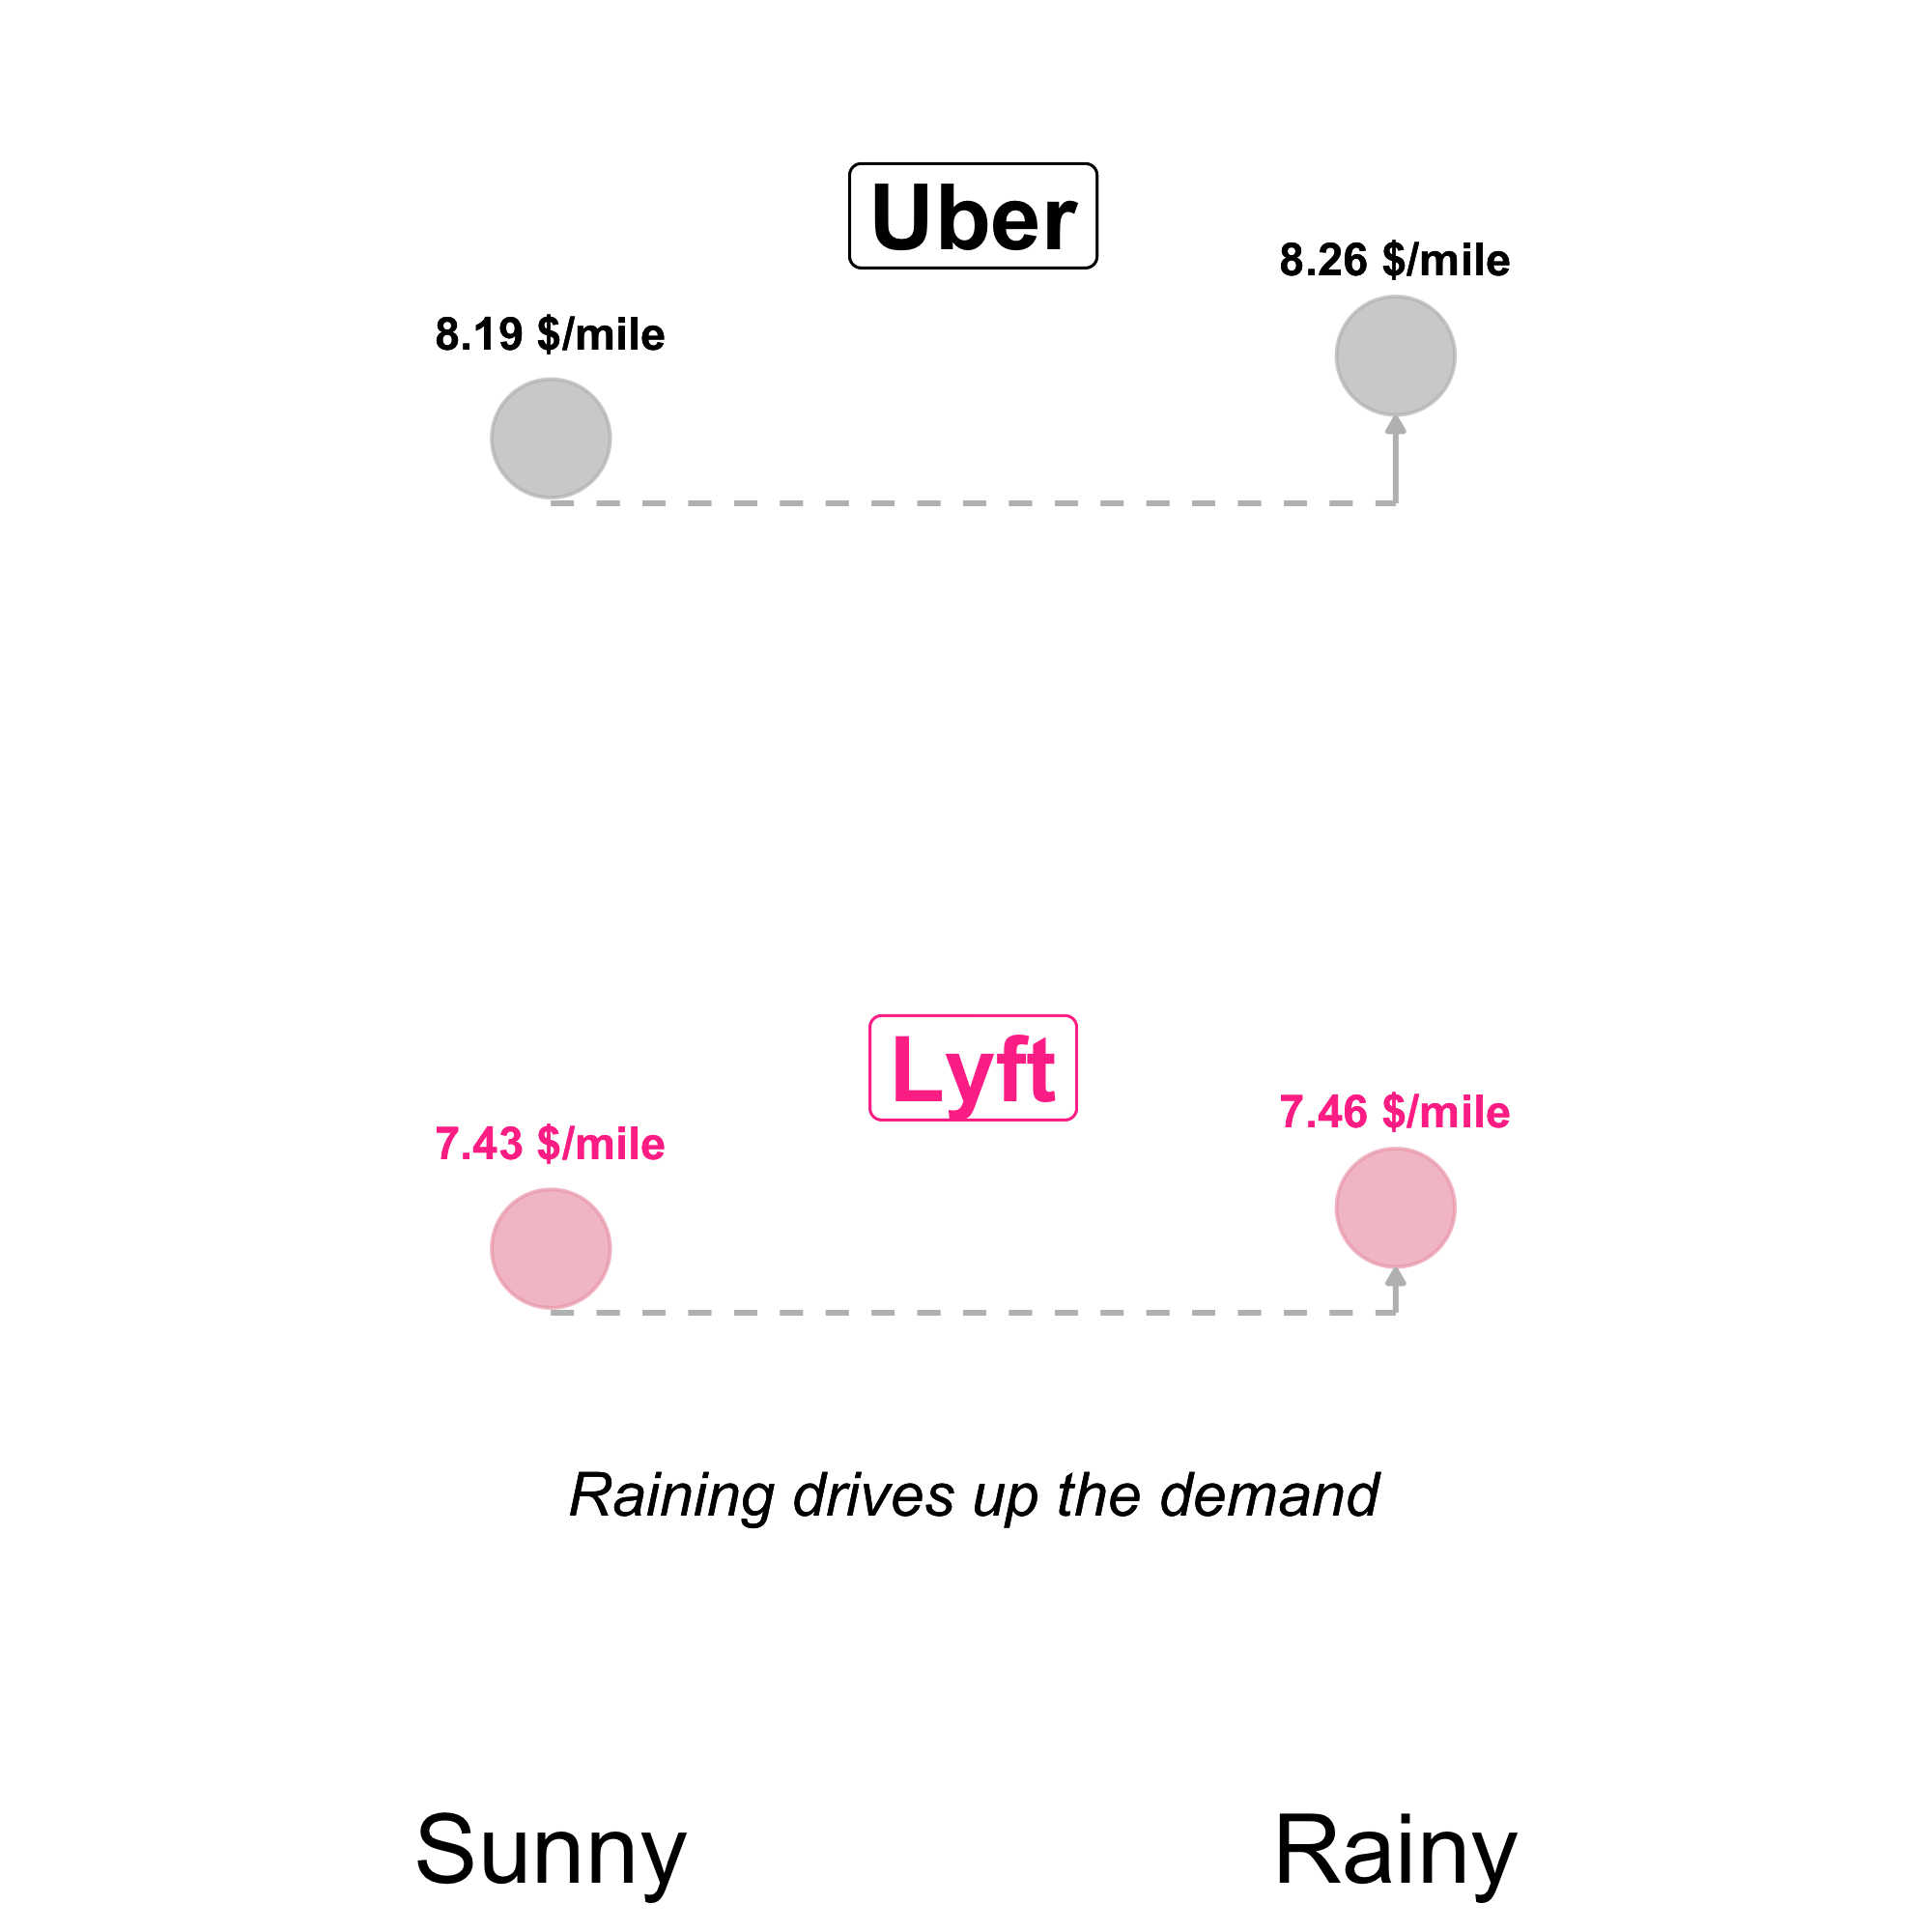

In [26]:
%%R -w 5 -h 5 --unit in -r 400
ggplot() +
    geom_point(aes(x=rain,y=Lyft), color ='pink2', size =10,
         data = rain_merge, alpha = 0.7)+
    geom_point(aes(x=rain,y=Uber), color ='grey', size =10,
         data = rain_merge, alpha = 0.7)+
    scale_y_continuous(limits = c(7,8.5), breaks = seq(7,8.5,by = 0.3))+
    geom_segment( aes(x =1 , xend = 2, y = 7.37, yend=7.37)
                 , data = rain_merge, size = 0.5, color = 'grey'
                 , linetype = 'dashed')+
    annotate("segment", x = 2, xend = 2, y = 7.37, yend = 7.41
             , arrow = arrow(type="closed",length = unit(0.1,"cm"))
             ,color = 'grey')+
    geom_segment( aes(x =1 , xend = 2, y = 8.13, yend= 8.13)
                 , data = rain_merge, size = 0.5, color = 'grey'
                 , linetype = 'dashed')+
    annotate("segment", x = 2, xend = 2, y = 8.13, yend = 8.21
             , arrow = arrow(type="closed",length = unit(0.1,"cm"))
             ,color = 'grey')+
    geom_label(aes(label= 'Uber',x = 1.5 , y = 8.4), 
           data = surge_lyft, size = 6,colour = 'black'
               ,fontface = "bold")+
    geom_label(aes(label= 'Lyft',x = 1.5 , y = 7.6), 
           data = surge_lyft, size = 6,colour = 'violetred1'
               ,fontface = "bold")+

    geom_text(aes(label= '7.43 $/mile',x = 1 , y = 7.53), 
           data = surge_lyft, size = 3,colour = 'violetred1'
              ,fontface = "bold")+
    geom_text(aes(label= '8.19 $/mile',x = 1 , y = 8.29), 
           data = surge_lyft, size = 3,colour = 'black'
              ,fontface = "bold")+

    geom_text(aes(label= '7.46 $/mile',x = 2 , y = 7.56), 
           data = surge_lyft, size = 3,colour = 'violetred1'
              ,fontface = "bold")+
    geom_text(aes(label= '8.26 $/mile',x = 2 , y = 8.36), 
           data = surge_lyft, size = 3,colour = 'black',fontface = "bold")+

    geom_text(aes(label= "Raining drives up the demand"
                  ,x = 1.5 , y = 7.2), 
           data = surge_lyft, size = 4,colour = 'black'
              ,fontface = "italic")+
    guides(fill=F)+ 
    theme_minimal()+
    theme(axis.text.y   = element_blank(),
        axis.text.x   = element_text(size=18, color = 'black'),
        axis.title.y  = element_blank(),
        axis.title.x  = element_blank(),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank())+
    ggsave('/Users/xuxupan/Desktop/6.png', units = 'in'
           , width = 5, height = 5)

Graph 6: Temperature
    --

In [27]:
dftmp =(df.groupby("cab_type").mean()
        [['above0','below0']].reset_index())
dftmp1 = dftmp[['cab_type','above0']]
dftmp1.columns = ['cab_type','unitp']
dftmp1['temp'] ="Above 32F"
dftmp2 = dftmp[['cab_type','below0']]
dftmp2.columns = ['cab_type','unitp']
dftmp2['temp'] ="Below 32F"
dftp = pd.concat([dftmp1,dftmp2],axis = 0)
dftplb = dftp.groupby('cab_type').mean()[['unitp']].reset_index()
dftp_uber = dftp[dftp.cab_type=='Uber']
dftp_lyft = dftp[dftp.cab_type=='Lyft']

In [28]:
%R -i dftp_uber
%R -i dftp_lyft

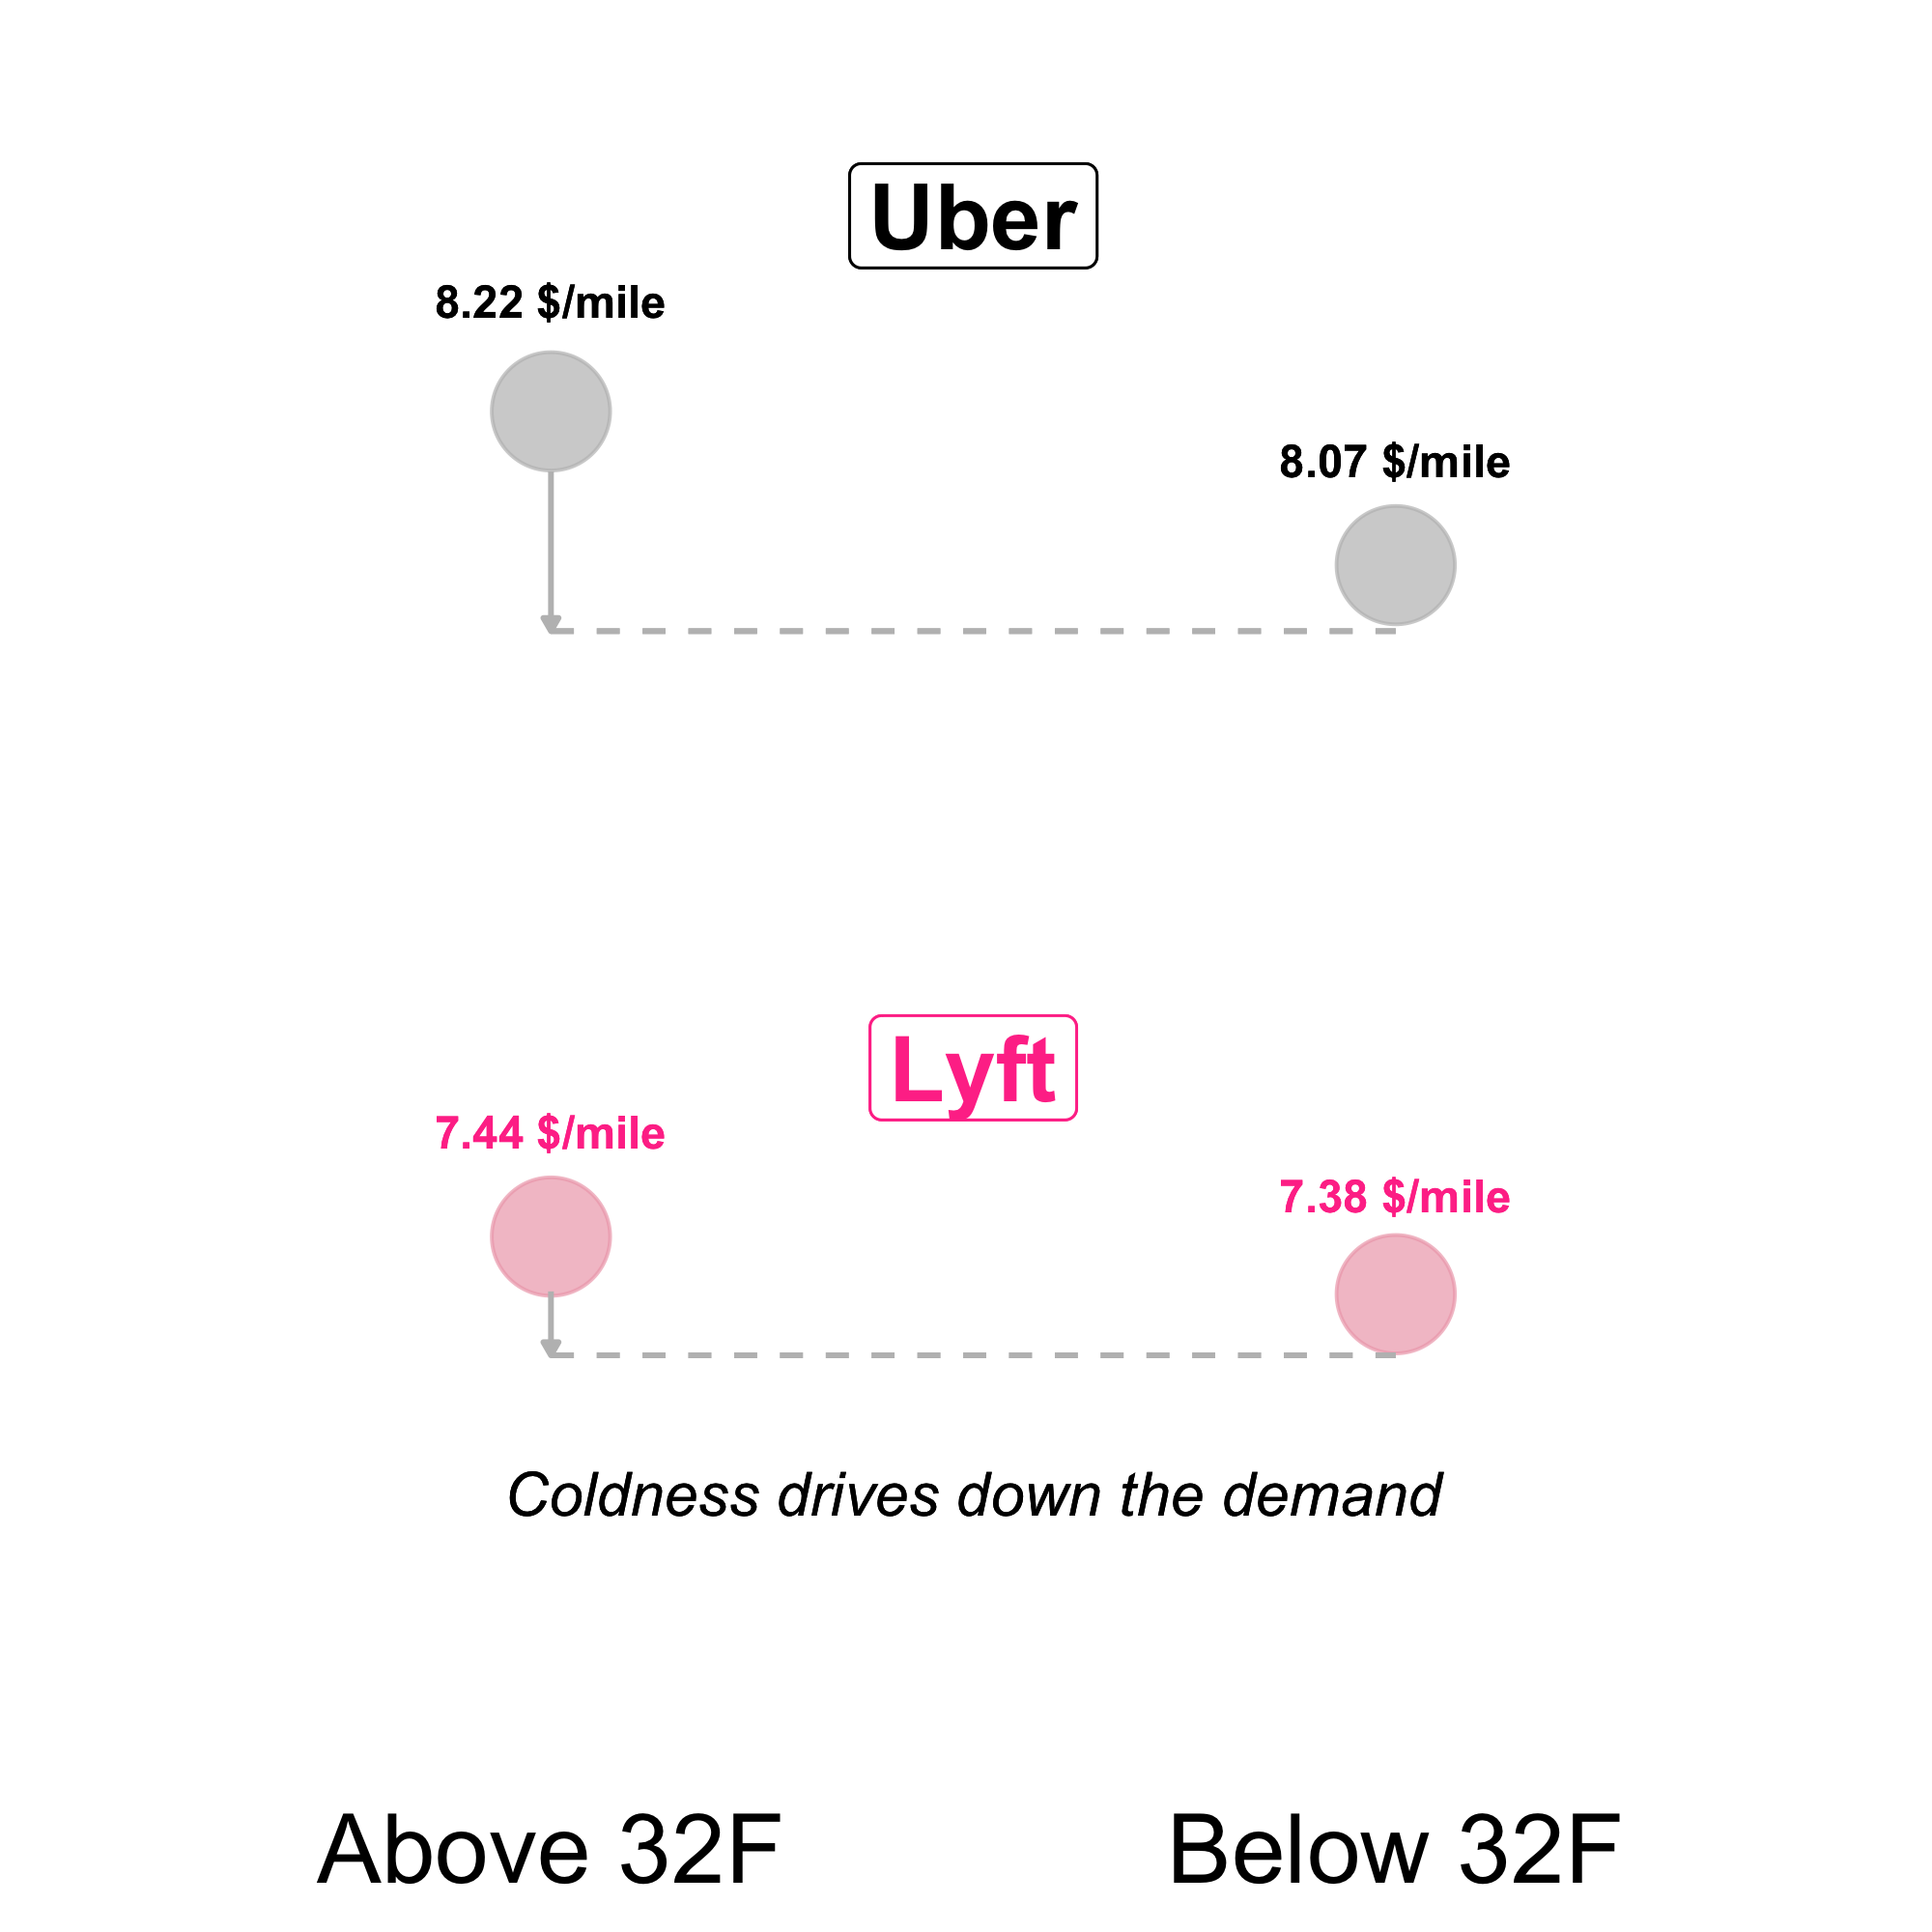

In [29]:
%%R -w 5 -h 5 --unit in -r 400
ggplot() +
    geom_point(aes(x=temp,y=unitp), color ='pink2', size =10,
         data = dftp_lyft, alpha = 0.7)+
    geom_point(aes(x=temp,y=unitp), color ='grey', size =10,
         data = dftp_uber, alpha = 0.7)+
    scale_y_continuous(limits = c(7,8.5)
                       , breaks = seq(7,8.5,by = 0.3))+
    geom_segment( aes(x =1 , xend = 2, y = 7.33, yend=7.33)
                 , data = rain_merge, size = 0.5, color = 'grey'
                 , linetype = 'dashed')+
    annotate("segment", x = 1, xend = 1, y = 8.16, yend = 8.01
             , arrow = arrow(type="closed",length = unit(0.1,"cm"))
             ,color = 'grey')+
    geom_segment( aes(x =1 , xend = 2, y = 8.01, yend= 8.01)
                 , data = rain_merge, size = 0.5, color = 'grey'
                 , linetype = 'dashed')+
    annotate("segment", x = 1, xend = 1, y = 7.39, yend = 7.33
             , arrow = arrow(type="closed",length = unit(0.1,"cm"))
             ,color = 'grey')+

    geom_label(aes(label= 'Uber',x = 1.5 , y = 8.4), 
           data = surge_lyft, size = 6,colour = 'black'
               ,fontface = "bold")+
    geom_label(aes(label= 'Lyft',x = 1.5 , y = 7.6), 
           data = surge_lyft, size = 6,colour = 'violetred1'
               ,fontface = "bold")+

    geom_text(aes(label= '7.38 $/mile',x = 2 , y = 7.48), 
           data = surge_lyft, size = 3,colour = 'violetred1'
              ,fontface = "bold")+
    geom_text(aes(label= '8.07 $/mile',x = 2 , y = 8.17), 
           data = surge_lyft, size = 3,colour = 'black'
              ,fontface = "bold")+

    geom_text(aes(label= '7.44 $/mile',x = 1 , y = 7.54), 
           data = surge_lyft, size = 3,colour = 'violetred1'
              ,fontface = "bold")+
    geom_text(aes(label= '8.22 $/mile',x = 1 , y = 8.32), 
           data = surge_lyft, size = 3,colour = 'black'
              ,fontface = "bold")+

    geom_text(aes(label= "Coldness drives down the demand"
                  ,x = 1.5 , y = 7.2), 
           data = surge_lyft, size = 4,colour = 'black',
              fontface = "italic")+
    guides(fill=F)+ 
    theme_minimal()+
    theme(axis.text.y   = element_blank(),
        axis.text.x   = element_text(size=18, color = 'black'),
        axis.title.y  = element_blank(),
        axis.title.x  = element_blank(),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank())+
    ggsave('/Users/xuxupan/Desktop/7.png', units = 'in'
           , width = 5, height = 5)